# Random Forest - Top model according to the SCPM of -2.81

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Processing
from sklearn.preprocessing import StandardScaler


# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

# Warnings
import warnings

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
def get_random_forest_df_importances(scores):
    importances = {}
    importances_with_column = []
    columns = x.columns

    for index, pipeline in enumerate(scores["estimator"]):
        model = pipeline.named_steps["estimator"]
        importances[index] = model.feature_importances_

    for index, importances_vec in importances.items():
        importances_col = pd.DataFrame(
            {col: [c] for col, c in zip(columns, importances_vec)},
            index=[f"Importances - {index}"],
        )
        importances_with_column.append(importances_col)
    df_importances = pd.concat(importances_with_column)

    return df_importances

<IPython.core.display.Javascript object>

In [4]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [5]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "209",
    "Plant": "W",
    "Features": "Chemical + Properties CS Less",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Random Forest",
    "Model Params": None,
    "Scaler": None,
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [6]:
df = pd.read_csv("../../../../data/processed/209/w.csv")

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep only chemical and mineralogical features yielded by the same testing method/procedure

In [7]:
df_copy = df.copy().drop(
    [
        "Cement_Type",
        "CS3",
        "CS7",
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

# 1. Decision Tree Regressor

In [8]:
PARAMS = {
    "criterion": "squared_error",
    "n_estimators": 5,
    "max_depth": 3,
    "random_state": SEED,
}

<IPython.core.display.Javascript object>

<h2>1. Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered. Only Chemical and mineralogical features measured by the same method. For this particular dataset, all chemical features, with the exception of LOI were measured by XRF and XRD methods.

In [9]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

## 1.3. Time Series Split Cross Validation

In [10]:
repeats = 3
n_splits = 5
gap = 0
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("estimator", RandomForestRegressor(**PARAMS)),
    ]
)
cv = TimeSeriesSplit(gap=gap, max_train_size=None, n_splits=n_splits, test_size=None)

scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
    return_indices=True,
)
print("Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Time Series Split"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 1, "Gap": 0}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -0.858 (0.059)
MAE: -0.632 (0.030)
MAPE: -0.015 (0.001)
R2: 0.970 (0.005)


******
[TEST]
******
RMSE: -1.055 (0.211)
MAE: -0.813 (0.132)
MAPE: -0.019 (0.003)
R2: 0.957 (0.019)




<IPython.core.display.Javascript object>

## Plotting the Predictions

In [11]:
# Store predictions for each fold
all_predictions = []

for idx, pipeline in enumerate(scores["estimator"]):
    index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    index_preds = np.concatenate([index_train, index_test])

    results = pipeline.predict(x.loc[index_preds])

    # Store predictions along with fold information
    fold_predictions = pd.DataFrame(
        {
            "DATE": dates[index_preds],
            "CS28": y[index_preds],
            "CS28_PRED": results,
            "SET": ["TRAIN"] * len(index_train) + ["TEST"] * len(index_test),
            "FOLD": [idx + 1] * len(index_preds),  # Indicate the fold number
        }
    )
    all_predictions.append(fold_predictions)

# Concatenate predictions from all folds
df_pred = pd.concat(all_predictions)
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

<IPython.core.display.Javascript object>

In [12]:
df_copy_merge = df_copy.reset_index(drop=True).merge(
    df_pred.reset_index(drop=True), left_index=True, right_index=True, how="inner"
)
df_copy_merge["COMPANY"] = 209
df_copy_merge["PLANT"] = "W"

for fold, (train_index, test_index) in enumerate(cv.split(x)):
    df_copy_merge.loc[train_index, "FOLD"] = fold + 1
    df_copy_merge.loc[test_index, "FOLD"] = fold + 1
df_copy_merge["FOLD"] = df_copy_merge["FOLD"].astype(int)
df_copy_merge.to_excel("local_model_random_forest_tsscv_209_w.xlsx", index=False)
df_copy_merge.to_csv("local_model_random_forest_tsscv_209_w.csv", index=False)

<IPython.core.display.Javascript object>

In [13]:
df_pred[["DATE", "CS28", "CS28_PRED", "SET"]]

,DATE,CS28,CS28_PRED,SET
0,2021-01-04,38.200001,37.832501,TRAIN
1,2021-01-05,47.100000,47.079042,TRAIN
2,2021-01-06,46.900000,47.263847,TRAIN
3,2021-01-06,38.200001,38.040767,TRAIN
4,2021-01-07,47.300000,47.414315,TRAIN
...,...,...,...,...
1006,2023-07-19,45.500000,47.084616,TEST
1007,2023-07-20,46.200001,47.084616,TEST
1008,2023-07-22,47.099998,47.084616,TEST
1009,2023-07-24,46.400002,47.084616,TEST


<IPython.core.display.Javascript object>

In [14]:
df_pred

,DATE,CS28,CS28_PRED,SET,FOLD
0,2021-01-04,38.200001,37.832501,TRAIN,1
1,2021-01-05,47.100000,47.079042,TRAIN,1
2,2021-01-06,46.900000,47.263847,TRAIN,1
3,2021-01-06,38.200001,38.040767,TRAIN,1
4,2021-01-07,47.300000,47.414315,TRAIN,1
...,...,...,...,...,...
1006,2023-07-19,45.500000,47.084616,TEST,5
1007,2023-07-20,46.200001,47.084616,TEST,5
1008,2023-07-22,47.099998,47.084616,TEST,5
1009,2023-07-24,46.400002,47.084616,TEST,5


<IPython.core.display.Javascript object>

In [15]:
(df_pred["SET"] == "TEST").sum()

840

<IPython.core.display.Javascript object>

In [16]:
df_pred["CS28"]

0       38.200001
1       47.100000
2       46.900000
3       38.200001
4       47.300000
          ...    
1006    45.500000
1007    46.200001
1008    47.099998
1009    46.400002
1010    46.799999
Name: CS28, Length: 3375, dtype: float64

<IPython.core.display.Javascript object>

In [17]:
matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

In [18]:
df[["CS28"]].describe().T

,count,mean,std,min,25%,50%,75%,max
CS28,1011.0,43.40366,5.143008,32.400002,37.0,46.400002,47.3,50.8


<IPython.core.display.Javascript object>

In [19]:
# Store predictions for each fold
all_predictions = []

for idx, pipeline in enumerate(scores["estimator"]):
    index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    index_preds = np.concatenate([index_train, index_test])

    results = pipeline.predict(x.loc[index_preds])

    # Store predictions along with fold information
    fold_predictions = pd.DataFrame(
        {
            "DATE": dates[index_preds],
            "CS28": y[index_preds],
            "CS28_PRED": results,
            "SET": ["TRAIN"] * len(index_train) + ["TEST"] * len(index_test),
            "FOLD": [idx + 1] * len(index_preds),  # Indicate the fold number
        }
    )
    all_predictions.append(fold_predictions)

# Concatenate predictions from all folds
df_pred = pd.concat(all_predictions)
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

<IPython.core.display.Javascript object>

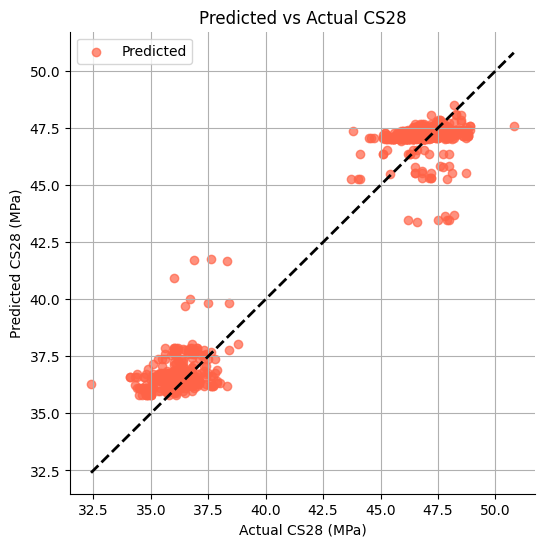

<IPython.core.display.Javascript object>

In [20]:
# Scatter plot of actual vs predicted values
test_data = df_pred[df_pred["SET"] == "TEST"]
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    label="Predicted",
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_cm_p_tiss_scpm_top_one_pred_vs_actual_cs28.png", dpi=300, bbox_inches="tight"
)
plt.show()

In [21]:
df_pred.shape, test_data.shape

((3375, 5), (840, 5))

<IPython.core.display.Javascript object>

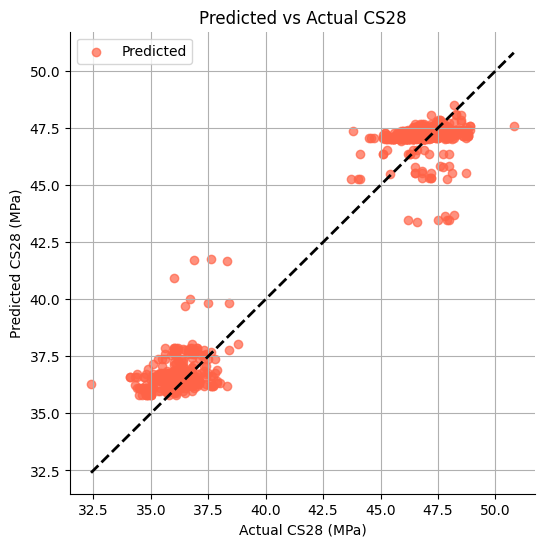

<IPython.core.display.Javascript object>

In [22]:
# Scatter plot of actual vs predicted values
test_data = df_pred[df_pred["SET"] == "TEST"]
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    label="Predicted",
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_cm_p_tiss_scpm_top_one_pred_vs_actual_cs28.png", dpi=300, bbox_inches="tight"
)
plt.show()

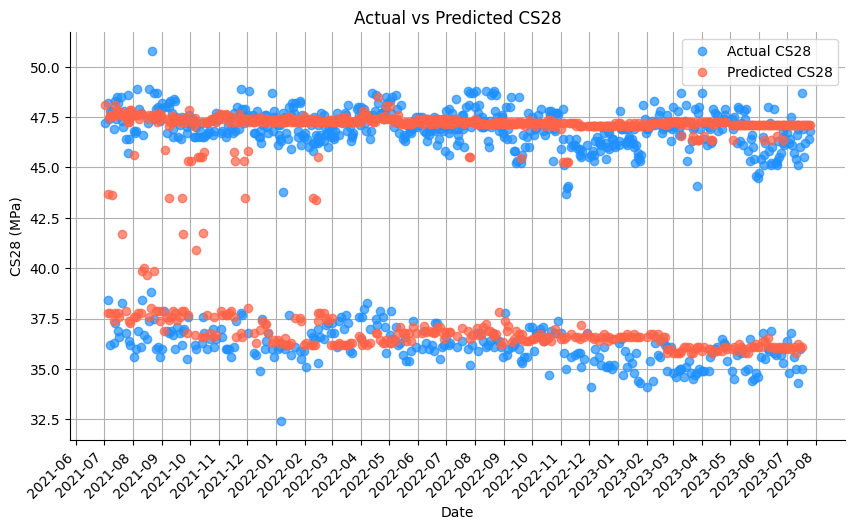

<IPython.core.display.Javascript object>

In [23]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend()
plt.grid(True)

# Improving x-axis readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set ticks for each month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format date as 'YYYY-MM-DD'
plt.gcf().autofmt_xdate(rotation=45)  # Rotate x-axis labels

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_cm_p_tiss_scpm_top_one_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


In [24]:
len(test_data), 175 * 5

(840, 875)

<IPython.core.display.Javascript object>

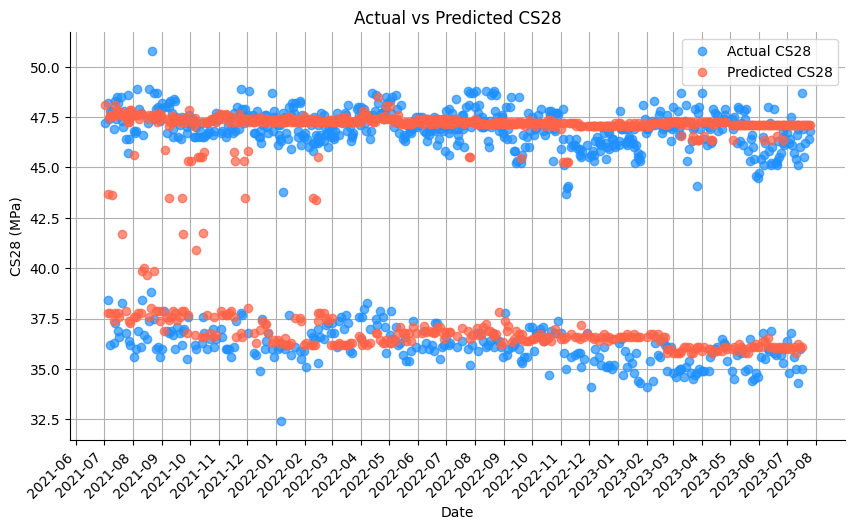

<IPython.core.display.Javascript object>

In [25]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend()
plt.grid(True)

# Improving x-axis readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set ticks for each month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format date as 'YYYY-MM-DD'
plt.gcf().autofmt_xdate(rotation=45)  # Rotate x-axis labels

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_cm_p_tiss_scpm_top_one_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


In [26]:
std_lower = []
std_higher = []

for train_idx, test_idx in cv.split(x):
    lower_range = y[train_idx][y[train_idx] < 40].std()
    higher_range = y[train_idx][y[train_idx] >= 40].std()
    std_lower.append(lower_range)
    std_higher.append(higher_range)

<IPython.core.display.Javascript object>

In [27]:
sorted(std_lower)

[0.8168003363003089,
 0.9257367760473988,
 0.9645410751924686,
 0.9890112427039995,
 1.0327200093841695]

<IPython.core.display.Javascript object>

In [28]:
sorted(std_higher)

[0.8534083370330955,
 0.8563367871443718,
 0.8848227895911746,
 0.9064718953357102,
 1.007750464019951]

<IPython.core.display.Javascript object>

In [29]:
df_pred["CS28"][(df_pred["CS28"] < 38) & (df_pred["SET"] == "TRAIN")].describe()

count    716.000000
mean      36.578631
std        0.806081
min       32.400002
25%       36.000000
50%       36.549999
75%       37.200001
max       37.900002
Name: CS28, dtype: float64

<IPython.core.display.Javascript object>

In [30]:
df_pred["CS28"][(df_pred["CS28"] > 44) & (df_pred["SET"] == "TRAIN")].describe()

count    1642.000000
mean       47.285323
std         0.875642
min        44.100000
25%        46.700000
50%        47.200000
75%        47.800000
max        50.800000
Name: CS28, dtype: float64

<IPython.core.display.Javascript object>

## Assessing Feature Importance

In [31]:
df_importances = get_random_forest_df_importances(scores)

<IPython.core.display.Javascript object>

In [32]:
df_importances

,Total C3S,Alpha C2S,Beta C2S,C4AF,C3A,Cubic C3A,Orthorhombic C3A,Free CaO,Portlandite,Periclase,...,SiO2,SO3,K2O,Fe2O3,Loss on Ignition,Insoluble Residue,Blaine,#325,Initial setting time,Final setting time
Importances - 0,0.193689,0.000000,0.002868,0.000000,0.000646,0.000000,0.0,0.010413,0.000000,0.000000,...,0.000000,0.008991,0.000000,0.001272,0.389735,0.000000,0.000000,0.191271,0.0,0.0
Importances - 1,0.000315,0.000000,0.000000,0.000067,0.000000,0.000000,0.0,0.000000,0.001574,0.000000,...,0.000000,0.000932,0.000000,0.001248,0.003919,0.000218,0.000000,0.786211,0.0,0.0
Importances - 2,0.002635,0.000300,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000609,0.000000,...,0.000362,0.001063,0.002339,0.001128,0.000849,0.000000,0.000000,0.791252,0.0,0.0
Importances - 3,0.001856,0.000191,0.000000,0.001318,0.000231,0.000427,0.0,0.000000,0.000000,0.000907,...,0.000000,0.000301,0.000181,0.000556,0.000000,0.000000,0.002163,0.983088,0.0,0.0
Importances - 4,0.004731,0.000000,0.000000,0.001999,0.000000,0.000000,0.0,0.000000,0.000000,0.001163,...,0.000000,0.000209,0.000000,0.001491,0.000145,0.000000,0.001566,0.982059,0.0,0.0


<IPython.core.display.Javascript object>

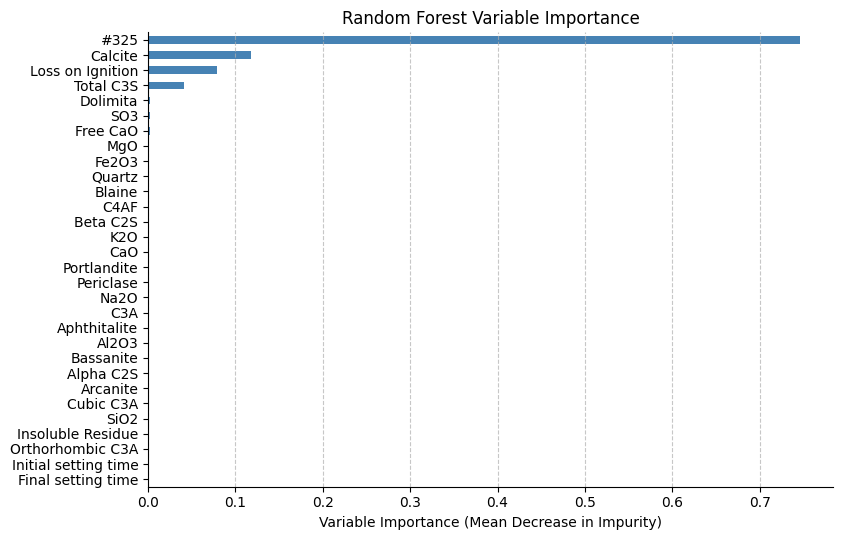

<IPython.core.display.Javascript object>

In [33]:
df_importances.mean(axis=0).sort_values().plot(
    kind="barh", figsize=(10, 5.5), color="steelblue"  # Consider using 'steelblue'
)
plt.title("Random Forest Variable Importance")
plt.xlabel("Variable Importance (Mean Decrease in Impurity)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.subplots_adjust(left=0.3)
plt.show()

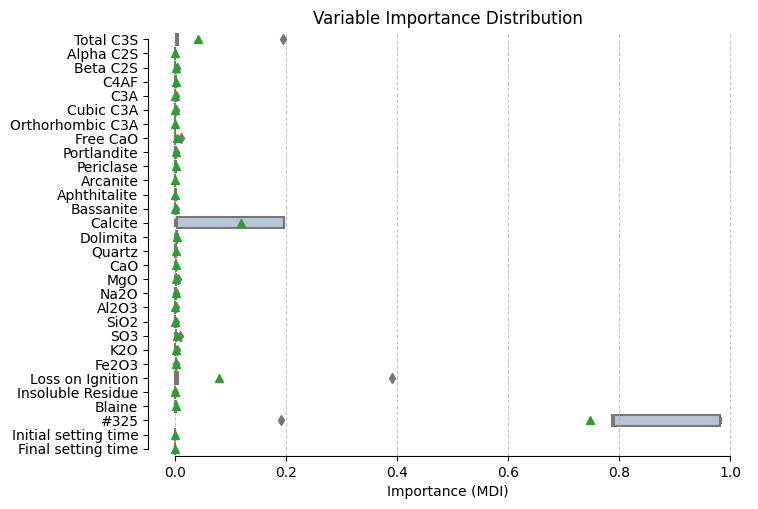

<IPython.core.display.Javascript object>

In [34]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(10, 5.5))
sns.boxplot(data=df_importances, orient="h", color="lightsteelblue", saturation=0.7, showmeans=True)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (MDI)")
plt.title("Variable Importance Distribution")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.show()


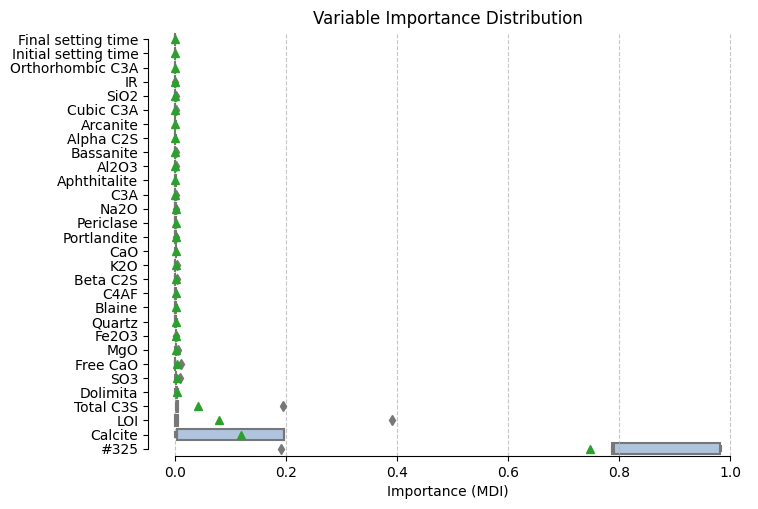

<IPython.core.display.Javascript object>

In [35]:
# Calculate the means of the importance scores
mean_importances = df_importances.mean()

# Sort the features by their mean relevance
sorted_features = mean_importances.sort_values()

# Re-order the DataFrame according to the sorted features
df_importances_sorted = df_importances[sorted_features.index]

# Plot the sorted boxplot
df_importances_sorted = df_importances_sorted.rename(
    columns={
        "Loss on Ignition": "LOI",
        "Insoluble Residue": "IR",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (MDI)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_cm_p_tiss_random_forest_scpm_best_dist_var_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [36]:
print("Default font family:", matplotlib.rcParams["font.family"])
print("Default sans-serif fonts:", matplotlib.rcParams["font.sans-serif"])
print("Default font size:", matplotlib.rcParams["font.size"])
print("Default font weight:", matplotlib.rcParams["font.weight"])

Default font family: ['sans-serif']
Default sans-serif fonts: ['DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif', 'Lucida Grande', 'Verdana', 'Geneva', 'Lucid', 'Arial', 'Helvetica', 'Avant Garde', 'sans-serif']
Default font size: 10.0
Default font weight: normal


<IPython.core.display.Javascript object>

In [37]:
plt.get_backend()

'module://matplotlib_inline.backend_inline'

<IPython.core.display.Javascript object>

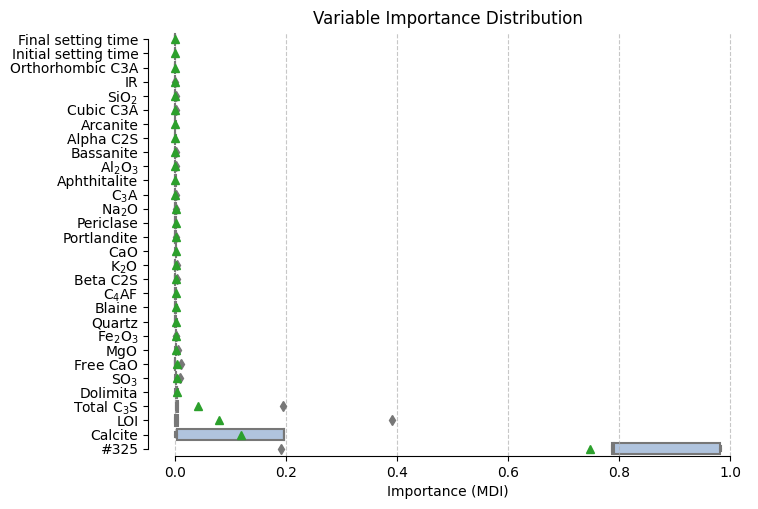

<IPython.core.display.Javascript object>

In [38]:
# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# plt.rcParams.update(
#     {
#         "mathtext.fontset": "custom",
#         "mathtext.rm": "DejaVu Sans",
#         "mathtext.it": "DejaVu Sans:italic",
#         "mathtext.bf": "DejaVu Sans:bold",
#     }
# )


# Convert chemical formulas using MathText syntax
df_importances_sorted_plot = df_importances_sorted.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (MDI)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_cm_p_tiss_random_forest_scpm_best_dist_var_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [39]:
df_importances

,Total C3S,Alpha C2S,Beta C2S,C4AF,C3A,Cubic C3A,Orthorhombic C3A,Free CaO,Portlandite,Periclase,...,SiO2,SO3,K2O,Fe2O3,Loss on Ignition,Insoluble Residue,Blaine,#325,Initial setting time,Final setting time
Importances - 0,0.193689,0.000000,0.002868,0.000000,0.000646,0.000000,0.0,0.010413,0.000000,0.000000,...,0.000000,0.008991,0.000000,0.001272,0.389735,0.000000,0.000000,0.191271,0.0,0.0
Importances - 1,0.000315,0.000000,0.000000,0.000067,0.000000,0.000000,0.0,0.000000,0.001574,0.000000,...,0.000000,0.000932,0.000000,0.001248,0.003919,0.000218,0.000000,0.786211,0.0,0.0
Importances - 2,0.002635,0.000300,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000609,0.000000,...,0.000362,0.001063,0.002339,0.001128,0.000849,0.000000,0.000000,0.791252,0.0,0.0
Importances - 3,0.001856,0.000191,0.000000,0.001318,0.000231,0.000427,0.0,0.000000,0.000000,0.000907,...,0.000000,0.000301,0.000181,0.000556,0.000000,0.000000,0.002163,0.983088,0.0,0.0
Importances - 4,0.004731,0.000000,0.000000,0.001999,0.000000,0.000000,0.0,0.000000,0.000000,0.001163,...,0.000000,0.000209,0.000000,0.001491,0.000145,0.000000,0.001566,0.982059,0.0,0.0


<IPython.core.display.Javascript object>

In [40]:
df_importances.describe().T

,count,mean,std,min,25%,50%,75%,max
Total C3S,5.0,0.040645,0.085569,0.000315,0.001856,0.002635,0.004731,0.193689
Alpha C2S,5.0,0.000098,0.000140,0.000000,0.000000,0.000000,0.000191,0.000300
Beta C2S,5.0,0.000574,0.001283,0.000000,0.000000,0.000000,0.000000,0.002868
C4AF,5.0,0.000677,0.000928,0.000000,0.000000,0.000067,0.001318,0.001999
C3A,5.0,0.000175,0.000282,0.000000,0.000000,0.000000,0.000231,0.000646
Cubic C3A,5.0,0.000085,0.000191,0.000000,0.000000,0.000000,0.000000,0.000427
Orthorhombic C3A,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Free CaO,5.0,0.002083,0.004657,0.000000,0.000000,0.000000,0.000000,0.010413
Portlandite,5.0,0.000437,0.000688,0.000000,0.000000,0.000000,0.000609,0.001574
Periclase,5.0,0.000414,0.000574,0.000000,0.000000,0.000000,0.000907,0.001163


<IPython.core.display.Javascript object>

In [41]:
df_importances.mean(axis=0)

Total C3S               0.040645
Alpha C2S               0.000098
Beta C2S                0.000574
C4AF                    0.000677
C3A                     0.000175
Cubic C3A               0.000085
Orthorhombic C3A        0.000000
Free CaO                0.002083
Portlandite             0.000437
Periclase               0.000414
Arcanite                0.000094
Aphthitalite            0.000171
Bassanite               0.000105
Calcite                 0.118036
Dolimita                0.002391
Quartz                  0.000934
CaO                     0.000462
MgO                     0.001596
Na2O                    0.000343
Al2O3                   0.000169
SiO2                    0.000072
SO3                     0.002299
K2O                     0.000504
Fe2O3                   0.001139
Loss on Ignition        0.078929
Insoluble Residue       0.000044
Blaine                  0.000746
#325                    0.746776
Initial setting time    0.000000
Final setting time      0.000000
dtype: flo

<IPython.core.display.Javascript object>

In [42]:
df_importances.std(axis=0)

Total C3S               0.085569
Alpha C2S               0.000140
Beta C2S                0.001283
C4AF                    0.000928
C3A                     0.000282
Cubic C3A               0.000191
Orthorhombic C3A        0.000000
Free CaO                0.004657
Portlandite             0.000688
Periclase               0.000574
Arcanite                0.000109
Aphthitalite            0.000245
Bassanite               0.000235
Calcite                 0.106440
Dolimita                0.001905
Quartz                  0.001298
CaO                     0.000295
MgO                     0.001831
Na2O                    0.000568
Al2O3                   0.000377
SiO2                    0.000162
SO3                     0.003760
K2O                     0.001029
Fe2O3                   0.000351
Loss on Ignition        0.173753
Insoluble Residue       0.000097
Blaine                  0.001043
#325                    0.325315
Initial setting time    0.000000
Final setting time      0.000000
dtype: flo

<IPython.core.display.Javascript object>

In [43]:
df_importances.std(axis=0, ddof=0)

Total C3S               0.076535
Alpha C2S               0.000125
Beta C2S                0.001147
C4AF                    0.000830
C3A                     0.000252
Cubic C3A               0.000171
Orthorhombic C3A        0.000000
Free CaO                0.004165
Portlandite             0.000616
Periclase               0.000514
Arcanite                0.000097
Aphthitalite            0.000219
Bassanite               0.000210
Calcite                 0.095203
Dolimita                0.001704
Quartz                  0.001161
CaO                     0.000264
MgO                     0.001637
Na2O                    0.000508
Al2O3                   0.000337
SiO2                    0.000145
SO3                     0.003363
K2O                     0.000920
Fe2O3                   0.000314
Loss on Ignition        0.155409
Insoluble Residue       0.000087
Blaine                  0.000933
#325                    0.290971
Initial setting time    0.000000
Final setting time      0.000000
dtype: flo

<IPython.core.display.Javascript object>

In [44]:
df_copy.nunique()

Date                     668
Total C3S                772
Alpha C2S                467
Beta C2S                 616
C4AF                     498
C3A                      428
Cubic C3A                356
Orthorhombic C3A         283
Free CaO                 256
Portlandite              275
Periclase                471
Arcanite                 284
Aphthitalite             161
Bassanite                492
Calcite                  635
Dolimita                 399
Quartz                   314
CaO                     1004
MgO                     1003
Na2O                     984
Al2O3                   1002
SiO2                    1003
SO3                     1001
K2O                      997
Fe2O3                   1002
Loss on Ignition         586
Insoluble Residue        510
Blaine                   159
#325                     139
Initial setting time      16
Final setting time        22
dtype: int64

<IPython.core.display.Javascript object>

In [45]:
pipeline.named_steps

{'imputer': SimpleImputer(strategy='median'),
 'estimator': RandomForestRegressor(max_depth=3, n_estimators=5, random_state=47)}

<IPython.core.display.Javascript object>

In [46]:
from sklearn.inspection import permutation_importance

<IPython.core.display.Javascript object>

In [47]:
# Initialize lists to store importance results
mdi_importances = []
perm_importances = []

# Compute feature importances
for i, (train_idx, test_idx) in enumerate(cv.split(x, y)):
    pipeline.fit(x.iloc[train_idx], y[train_idx])

    # Extract the trained model
    model = pipeline.named_steps["estimator"]
    imputer = pipeline.named_steps["imputer"]
    # Compute MDI importance
    mdi_importances.append(model.feature_importances_)

    # Compute permutation importance
    result = permutation_importance(
        model,
        imputer.transform(x.iloc[test_idx]),
        y[test_idx],
        n_repeats=10,
        random_state=SEED,
        n_jobs=-1,
        # scoring="neg_mean_squared_error",
        scoring="r2",
    )
    perm_importances.append(result.importances_mean)

<IPython.core.display.Javascript object>

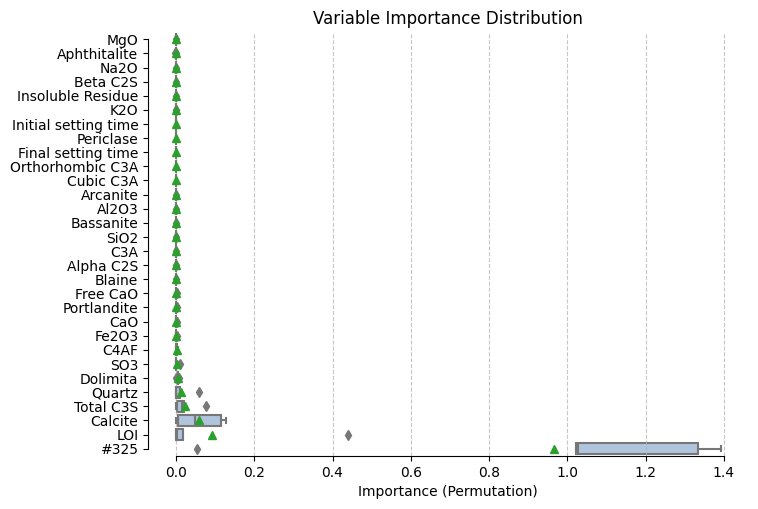

<IPython.core.display.Javascript object>

In [48]:
# Convert lists to DataFrames
mdi_importances_df = pd.DataFrame(mdi_importances, columns=x.columns)
perm_importances_df = pd.DataFrame(perm_importances, columns=x.columns)


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]

perm_importances_df = perm_importances_df.rename(columns={"Loss on Ignition": "LOI"})


plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_cm_p_tiss_random_forest_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)

# # Step 3: Reset all rcParams to their default values
plt.rcdefaults()

plt.show()

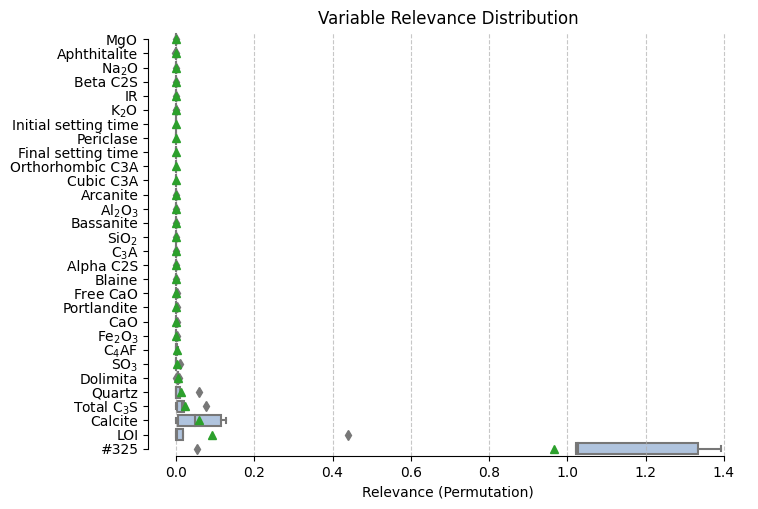

<IPython.core.display.Javascript object>

In [49]:
# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Permutation)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_cm_p_tiss_random_forest_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

plt.show()

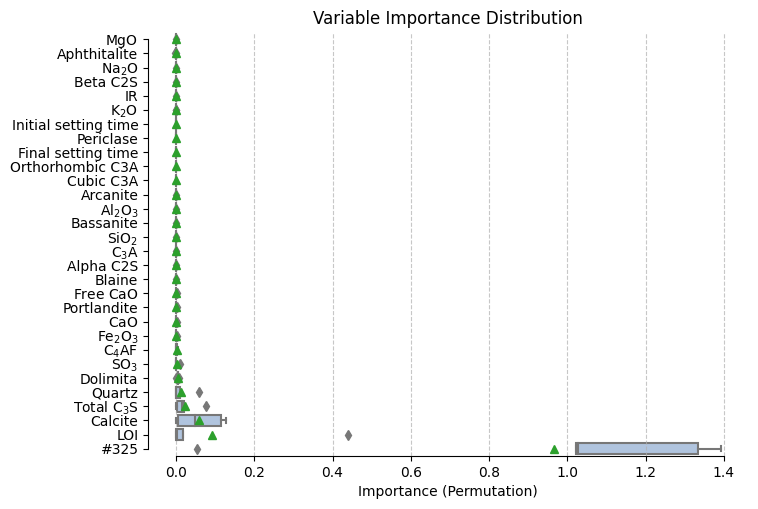

<IPython.core.display.Javascript object>

In [50]:
import matplotlib.ticker as mticker

# Step 1: Define a function to format the x-axis to one decimal place
def one_decimal(x, pos):
    return f'{x:.1f}'

# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR"
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)

# Step 2: Apply the formatter to the x-axis
ax = plt.gca()  # Get the current axis
ax.xaxis.set_major_formatter(mticker.FuncFormatter(one_decimal))

plt.savefig(
    "ecics_cm_p_tiss_random_forest_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)

# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

plt.show()


In [51]:
perm_importances_df.describe().T

,count,mean,std,min,25%,50%,75%,max
MgO,5.0,-0.000243,0.000543,-0.001215,0.000000,0.000000,0.000000,0.000000
Aphthitalite,5.0,-0.000228,0.000832,-0.001660,0.000000,0.000000,0.000000,0.000520
Na2O,5.0,-0.000137,0.000301,-0.000676,-0.000011,0.000000,0.000000,0.000000
Beta C2S,5.0,-0.000113,0.000253,-0.000566,0.000000,0.000000,0.000000,0.000000
Insoluble Residue,5.0,-0.000050,0.000113,-0.000252,0.000000,0.000000,0.000000,0.000000
K2O,5.0,-0.000003,0.000015,-0.000029,0.000000,0.000000,0.000000,0.000013
Initial setting time,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Periclase,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Final setting time,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Orthorhombic C3A,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<IPython.core.display.Javascript object>